### Functions

In [31]:
import requests, random

def ontop(query:str):
    return requests.post(
    'http://localhost:8081/sparql',
    headers={
        'Accept': 'application/sparql-results+json',
        'Content-Type': 'application/x-www-form-urlencoded',
    },
    data={
        'query': query,
    },
    )

def fuseki(query:str):
    return requests.post(
    'http://localhost:3030/test/sparql',
    headers={
        'Accept': 'application/sparql-results+json',
        'Content-Type': 'application/x-www-form-urlencoded',
    },
    data={
        'query': query,
    },
    )

def graphDB(query:str):
    return requests.post(
    'http://localhost:7200/repositories/ghcnd',
    headers={
        'Accept': 'application/sparql-results+json',
        'Content-Type': 'application/x-www-form-urlencoded',
    },
    data={
        'query': query,
    },
    )

def date_range(num, length):
    array=[]
    for i in random.sample(range(1950,2012), num):
        array.append((i,i+length-1))
    return array

def create_row(query, period):
    row = [ontop(query%period).elapsed.total_seconds(), fuseki(query%period).elapsed.total_seconds(),graphDB(query%period).elapsed.total_seconds()]
    return row

### Queries

In [70]:
# two-variable ts
query_2_ts = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX : <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/>

BASE <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/>

PREFIX car_type: <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/resource/datatype/>

PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?prcp ?tmax ?date WHERE { #2
  ?prcp_obs sosa:madeBySensor <resource/sensor/EI000003969>;
         sosa:hasSimpleResult ?prcp;
         sosa:observedProperty car_type:PRCP;
         :aggregatedOnDate ?date .
  {
    SELECT ?tmax ?date WHERE{ #1
    ?tmax_obs sosa:madeBySensor <resource/sensor/EI000003969>;
    						sosa:hasSimpleResult ?tmax; 
    						sosa:observedProperty car_type:TMAX;
 							:aggregatedOnDate ?date .
    FILTER(YEAR(?date)>=%s && YEAR(?date)<=%s)
   }
    order by ?date
  } 
}
order by ?date
'''

query_3_ts = '''
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

PREFIX : <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/>

BASE <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/>

PREFIX car_type: <http://www.semanticweb.org/jiantaowu/ontologies/2022/3/CubeCA/resource/datatype/>

PREFIX sosa: <http://www.w3.org/ns/sosa/>

PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?prcp ?tmax ?tmin ?date WHERE { #3
  ?prcp_obs sosa:madeBySensor <resource/sensor/EI000003969>;
         sosa:hasSimpleResult ?prcp;
         sosa:observedProperty car_type:PRCP;
         :aggregatedOnDate ?date .
  {
    SELECT ?tmax ?tmin ?date WHERE{ #2
    ?tmax_obs sosa:madeBySensor <resource/sensor/EI000003969>;
              sosa:hasSimpleResult ?tmax; 
              sosa:observedProperty car_type:TMAX;
              :aggregatedOnDate ?date .
      {
      	SELECT ?tmin ?date WHERE{ #1
    		?tmax_obs sosa:madeBySensor <resource/sensor/EI000003969>;
              sosa:hasSimpleResult ?tmin; 
              sosa:observedProperty car_type:TMIN;
              :aggregatedOnDate ?date .
     		FILTER(YEAR(?date)>=%s && YEAR(?date)<=%s)
      	}
        order by ?date
      }
   }
    order by ?date
  } 
}
order by ?date
'''

### Charts

#### constants

#### functions

In [114]:
import pandas as pd
def one_chart(query, random_rows, num_of_years):
    ary_periods = date_range(random_rows, num_of_years)
    data = {}
    for period in ary_periods:
        row = create_row(query, period)
        data[str(period)] = row
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Ontop-PostgreSQL', 'Apache Jena Fuseki', 'GraphDB'])
    return df

#### Analysis

In [24]:
max_year = 10
random_entries = 5

In [110]:
## two-var ts
lst_dfs = []
max_year = 10
random_entries = 5


for i in range(max_year):
    df = one_chart(query_2_ts,random_entries,i+1)
    lst_dfs.append(df)

df_all =  pd.DataFrame()

for i in range(max_year):
    df = pd.DataFrame()
    df['cost'] = lst_dfs[i].mean(axis = 0)
    df['year(s)'] = i+1
    df = df.reset_index(level=0)
    df_all = df_all.append(df, ignore_index=True)
    
df_all['num_variable'] = 2

/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/241579684.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df, ignore_index=True)
/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/241579684.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df, ignore_index=True)
/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/241579684.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df, ignore_index=True)
/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/241579684.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

In [112]:
df_all

,index,cost,year(s),num_variable
0,Ontop-PostgreSQL,0.348183,1,2
1,Apache Jena Fuseki,0.684939,1,2
2,GraphDB,1.204717,1,2
3,Ontop-PostgreSQL,0.346116,2,2
4,Apache Jena Fuseki,0.678481,2,2
5,GraphDB,1.171707,2,2
6,Ontop-PostgreSQL,0.377139,3,2
7,Apache Jena Fuseki,0.674314,3,2
8,GraphDB,1.366811,3,2
9,Ontop-PostgreSQL,0.379840,4,2


In [104]:
## three-var ts
lst_dfs_3 = []
max_year = 10
random_entries = 5


for i in range(max_year):
    df = one_chart(query_3_ts,random_entries,i+1)
    lst_dfs_3.append(df)

df_all_3 =  pd.DataFrame()

for i in range(max_year):
    df = pd.DataFrame()
    df['cost'] = lst_dfs_3[i].mean(axis = 0)
    df['year(s)'] = i+1
    df = df.reset_index(level=0)
    df_all_3 = df_all_3.append(df, ignore_index=True)

df_all_3['num_variable'] = 3
    


/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/2287876452.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_3 = df_all_3.append(df, ignore_index=True)
/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/2287876452.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all_3 = df_all_3.append(df, ignore_index=True)


In [105]:
df_all_3

,index,cost,year(s),num_variable
0,Ontop-PostgreSQL,0.464132,1,3
1,Apache Jena Fuseki,0.994551,1,3
2,GraphDB,1.493673,1,3
3,Ontop-PostgreSQL,0.498179,2,3
4,Apache Jena Fuseki,0.993113,2,3
5,GraphDB,1.541059,2,3


### Figures

In [106]:
df = df_all.append(df_all_3, ignore_index=True)

/var/folders/8m/wb8xgy694zvddt58c2wzjz_80000gn/T/ipykernel_19478/2121673267.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_all.append(df_all_3, ignore_index=True)


In [107]:
df

,index,cost,year(s),num_variable
0,Ontop-PostgreSQL,0.372407,1,2
1,Apache Jena Fuseki,0.687194,1,2
2,GraphDB,1.346377,1,2
3,Ontop-PostgreSQL,0.360165,2,2
4,Apache Jena Fuseki,0.677372,2,2
5,GraphDB,1.478304,2,2
6,Ontop-PostgreSQL,0.464132,1,3
7,Apache Jena Fuseki,0.994551,1,3
8,GraphDB,1.493673,1,3
9,Ontop-PostgreSQL,0.498179,2,3


<AxesSubplot:xlabel='year(s)', ylabel='cost'>

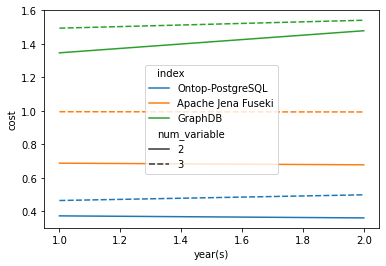

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df, x="year(s)", y="cost", hue="index", style="num_variable")